episode :0, total reward : 30.0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class '

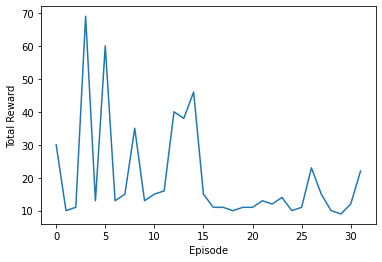

Total Reward: 10.0


In [9]:
import copy
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L
import pygame


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done


class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(256)
        self.l3 = L.Linear(128)
        self.l4 = L.Linear(64)
        self.l5 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        return x


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = \
            self.replay_buffer.get_batch()
        print(type(state))
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)


episodes = 32
sync_interval = 20
env = gym.make('CartPole-v1')
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}".format(episode, total_reward))


# === Plot ===
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(range(len(reward_history)), reward_history)
plt.show()


# === Play CartPole ===
agent.epsilon = 0  # greedy policy
state = env.reset()
done = False
total_reward = 0

pygame.init()
while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    total_reward += reward
    env.render()
print('Total Reward:', total_reward)
pygame.quit()
